## Importing the libraries and starting the PySpark session
Let's start the analysis by importing the required libraries related to `Pyspark`, `Matplotlib`, `Numpy` and `Pandas`

In [ ]:
from pyspark import SparkFiles

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, current_date, datediff, floor, expr, sum, avg, explode, collect_set, lower, udf
from pyspark.sql.types import IntegerType, ArrayType, StringType
from pyspark.sql.functions import mean, when, array, array_contains

from pyspark.ml.feature import Imputer
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Creating a Spark Session
Let's initialize a spark session which connects to the local mongoDB. We have the data stored in `airbnb_data` collection in `project_budt737` database.

In [ ]:
spark = SparkSession.builder \
    .appName("MongoDBExportToCSV") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/project_budt737.airbnb_data") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/project_budt737.airbnb_data") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .getOrCreate()

# Set log level to ERROR to reduce verbosity
spark.sparkContext.setLogLevel("ERROR")

24/03/11 03:07:37 WARN Utils: Your hostname, Bharaths-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.210 instead (on interface en0)
24/03/11 03:07:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/Users/bharath/anaconda3/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/bharath/.ivy2/cache
The jars for the packages stored in: /Users/bharath/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-865b9bc4-e417-4b17-881f-989e51538388;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
:: resolution report :: resolve 317ms :: artifacts dl 22ms
	:: modules in use:
	org.mongodb#bson;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-core;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-sync;4.0.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artif

## Loading the dataset
We'll load all the documents present in MongoDB and load it to a Dataframe. We initially had 494954 records in the main dataset provided by opendatasoft. Due to our system constraints we are using only 10000 records. This data is already stored in our local mongoDB which we'll read it to the dataframe directly.

In [ ]:
airbnb_json = spark.read.format("mongo").load()

In [ ]:
# displaying the number of observations in the dataset
print("Number of observations:",airbnb_json.count())

Number of observations: 10000


## Filtering the data
Now let's do some basic filtering on the data. We aren't using all the 85 fields present in our dataset. We'll be selecting a few ones which will be useful for our analysis.

In [ ]:
airbnb_filtered = airbnb_json.select(['experiences_offered', 'host_since', 'host_response_rate', 'host_listings_count',
                'neighbourhood', 'state', 'city', 'market', 'country', 'property_type', 'room_type', 'cancellation_policy',
                'accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet', 'price',
                'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included', 'number_of_reviews',
                'extra_people', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'review_scores_value',
                'availability_90', 'amenities'])

#### Adding column - years_host_since
We are adding a new column `years_host_since` which will convert the host_since which was of date format to integer format years

In [ ]:
# Convert "Host Since" column from string to date type
airbnb_filtered = airbnb_filtered.withColumn("host_since", expr("date_format(to_date(`host_since`, 'yyyy-MM-dd'), 'yyyy-MM-dd')"))

# Calculate the number of years since "Host Since" date
years_since_host_since = floor(datediff(current_date(), "host_since") / 365).cast(IntegerType())

# Add the calculated years since "Host Since" date as a new column
airbnb_filtered = airbnb_filtered.withColumn("years_host_since", years_since_host_since)

# dropping the column Host Since
airbnb_filtered = airbnb_filtered.drop("host_since")

#### Checking for null values


In [ ]:
null_counts = airbnb_filtered.select([sum(col(column).isNull().cast("int")).alias(column) for column in airbnb_filtered.columns])

null_counts.show()

+-------------------+------------------+-------------------+-------------+-----+----+------+-------+-------------+---------+-------------------+------------+---------+--------+----+-----------+-----+------------+-------------+----------------+------------+---------------+-----------------+------------+--------------+--------------+---------------+---------------+-------------------+---------------+---------+----------------+
|experiences_offered|host_response_rate|host_listings_count|neighbourhood|state|city|market|country|property_type|room_type|cancellation_policy|accommodates|bathrooms|bedrooms|beds|square_feet|price|weekly_price|monthly_price|security_deposit|cleaning_fee|guests_included|number_of_reviews|extra_people|minimum_nights|maximum_nights|availability_30|availability_60|review_scores_value|availability_90|amenities|years_host_since|
+-------------------+------------------+-------------------+-------------+-----+----+------+-------+-------------+---------+------------------

In [ ]:
# checking the data types of the columns
airbnb_filtered.dtypes

[('experiences_offered', 'string'),
 ('host_response_rate', 'int'),
 ('host_listings_count', 'int'),
 ('neighbourhood', 'string'),
 ('state', 'string'),
 ('city', 'string'),
 ('market', 'string'),
 ('country', 'string'),
 ('property_type', 'string'),
 ('room_type', 'string'),
 ('cancellation_policy', 'string'),
 ('accommodates', 'int'),
 ('bathrooms', 'double'),
 ('bedrooms', 'int'),
 ('beds', 'int'),
 ('square_feet', 'string'),
 ('price', 'int'),
 ('weekly_price', 'string'),
 ('monthly_price', 'string'),
 ('security_deposit', 'int'),
 ('cleaning_fee', 'int'),
 ('guests_included', 'int'),
 ('number_of_reviews', 'int'),
 ('extra_people', 'int'),
 ('minimum_nights', 'int'),
 ('maximum_nights', 'int'),
 ('availability_30', 'int'),
 ('availability_60', 'int'),
 ('review_scores_value', 'int'),
 ('availability_90', 'int'),
 ('amenities', 'array<string>'),
 ('years_host_since', 'int')]

#### Imputing the NULL values
Datasets always have missing values. Where there aren't a lot of missing values we are imputing them with the average value in the dataset. Cases where there are a lot of null values, we will drop the column from the dataset.

In [ ]:
impute_avg_cols = ['host_response_rate', 'host_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
                   'price', 'security_deposit', 'cleaning_fee', 'review_scores_value',
                   'years_host_since']
impute_sp_cols = ['neighbourhood', 'state', 'city', 'market', 'amenities']

In [ ]:
# Calculate the average value for each column
averages = airbnb_filtered.select([
    avg(column).alias(column) for column in impute_avg_cols
]).collect()[0]

# Extract the average values
average_values = {column: avg_value for column, avg_value in zip(impute_avg_cols, averages)}

# Impute NaN values with the average value for each column
for column in impute_avg_cols:
    airbnb_filtered = airbnb_filtered.fillna(average_values[column], subset=[column])

In [ ]:
# Define the columns with missing values
columns_with_missing_values = ['square_feet', 'weekly_price', 'monthly_price']

# Drop the columns
for col_name in columns_with_missing_values:
    airbnb_filtered = airbnb_filtered.drop(col_name)

In [ ]:
# Impute null values with 'Not Mentioned'
for col_name in impute_sp_cols:
    airbnb_filtered = airbnb_filtered.fillna('Not Mentioned', subset=[col_name])

In [ ]:
# CHECKING FOR NULL VALUES AGAIN
# seeing the null values in each column

# Replace 'airbnb_ps' with your DataFrame name
null_counts = airbnb_filtered.select([sum(col(column).isNull().cast("int")).alias(column) for column in impute_avg_cols])

# Display the counts of null values
null_counts.show()

+------------------+-------------------+------------+---------+--------+----+-----+----------------+------------+-------------------+----------------+
|host_response_rate|host_listings_count|accommodates|bathrooms|bedrooms|beds|price|security_deposit|cleaning_fee|review_scores_value|years_host_since|
+------------------+-------------------+------------+---------+--------+----+-----+----------------+------------+-------------------+----------------+
|                 0|                  0|           0|        0|       0|   0|    0|               0|           0|                  0|               0|
+------------------+-------------------+------------+---------+--------+----+-----+----------------+------------+-------------------+----------------+



## Separating the amenities
The amenities offered is important in learning and analysing more on the airbnb properties. Here we have a list of amenities under each property. We'll find the unique amenities present in the dataset and make separate columns for each amenity and it will have value as 0 or 1.

In [ ]:
airbnb_filtered.select('amenities').show(3, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|amenities                                                                                                                                                                                            |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[TV, Kitchen, Heating, Family/kid friendly, Smoke detector, Fire extinguisher, Essentials, Shampoo, Lock on bedroom door, 24-hour check-in, Hangers, Hair dryer, Iron]                               |
|[TV, Wireless Internet, Kitchen, Smoking allowed, Heating, Essentials, Shampoo, Hangers, Iron]                                                                                                       |


In [ ]:
# Explode the 'amenities' array column into separate rows
exploded_amenities = airbnb_filtered.select(explode(col("amenities")).alias("amenity"))

# Find the distinct amenities
distinct_amenities = exploded_amenities.select(lower(col("amenity")).alias("amenity")).distinct()

# Collect the distinct amenities into a list
unique_amenities_list = [row['amenity'] for row in distinct_amenities.collect()]

In [ ]:
def to_lower_case(amenities_array):
  if amenities_array is not None:
      return [amenity.lower() for amenity in amenities_array]
  else:
      return []

# Register UDF
to_lower_case_udf = udf(to_lower_case, ArrayType(StringType()))

# Convert amenities array in each row to lower case
airbnb_filtered = airbnb_filtered.withColumn("amenities_lower", to_lower_case_udf(col("amenities")))

# Now, generate a new DataFrame with columns for each amenity
for amenity in unique_amenities_list:
    airbnb_filtered = airbnb_filtered.withColumn(amenity, array_contains(col("amenities_lower"), amenity).cast("integer"))

In [ ]:
# deleting the column - amenities
airbnb_filtered = airbnb_filtered.drop("amenities")

In [ ]:
airbnb_filtered.show(1)

+-------------------+------------------+-------------------+--------------------+-------------+-----+------+-------+-------------+------------+-------------------+------------+---------+--------+----+-----+----------------+------------+---------------+-----------------+------------+--------------+--------------+---------------+---------------+-------------------+---------------+----------------+--------------------+------------+----------------+-----+----------------------+-----------------------------+------------+--------------------------------+------------+--------------+-------+----------------+--------------+-------+-------------------+------------+-----------------------+------------------------+------------+-----------+----+---+--------------------------+------------------+----+------------------------+-------------------------+----------+---------------------+-----------------+-------+----+-------+-----------+--------------------------+-----------------+-------------------+---

## Encoding
We are converting categorical variables to numerical variables using String Indexing and One Hot Encoding as the models only understand numerical variables. We also willuse Vector assembler and combine all the variables we need to 1 variable as the models take only 1 variable as input.

In [ ]:
str_columns = ['experiences_offered', 'neighbourhood', 'state', 'city', 'market', 'country', 'property_type', 'room_type', 'cancellation_policy']

In [ ]:
# STRING INDEXING
str_idx = StringIndexer(inputCols = str_columns,
                        outputCols = ['Experiences_Offered_str', 'Neighbourhood_str', 'State_str', 'City_str', 'Market_str', 'Country_str', 'Property_Type_str', 'Room_Type_str', 'Cancellation_Policy_str'],
                        stringOrderType = 'alphabetAsc', handleInvalid='keep')

In [ ]:
# ONE HOT ENCODING
onehot = OneHotEncoder(inputCols = ['Experiences_Offered_str', 'Neighbourhood_str', 'State_str', 'City_str', 'Market_str', 'Country_str', 'Property_Type_str', 'Room_Type_str', 'Cancellation_Policy_str'],
                     outputCols = ['Experiences_Offered_new', 'Neighbourhood_new', 'State_new', 'City_new', 'Market_new', 'Country_new', 'Property_Type_new', 'Room_Type_new', 'Cancellation_Policy_new'])

In [ ]:
# using PIPELINE to perform both string indexing and one hot encoding together
mypipeline = Pipeline(stages=[str_idx,onehot])
cleaned_airbnb_data = mypipeline.fit(airbnb_filtered).transform(airbnb_filtered)

In [ ]:
var_clustering = ['Country_new', 'price', 'review_scores_value', 'security_deposit', 'number_of_reviews']

In [ ]:
# using VECTOR ASSEMBLER to merge all independent variables into one
vec_obj = VectorAssembler(inputCols = var_clustering,
                          outputCol = "all_features")

try_airbnb_data = vec_obj.transform(cleaned_airbnb_data)

## Finding the best k value for clustering

In [ ]:
# Computing WSSSE for K values from 2 to 8
wssse_values =[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='all_features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,8):
    KMeans_mod = KMeans(featuresCol='all_features', k=i)
    KMeans_fit = KMeans_mod.fit(try_airbnb_data)
    output = KMeans_fit.transform(try_airbnb_data)
    score = evaluator.evaluate(output)
    wssse_values.append(score)
    print("Silhouette Score:",score)

Silhouette Score: 0.8500190012190763
Silhouette Score: 0.8207033058524812


Silhouette Score: 0.6829563068280073
Silhouette Score: 0.6690914699432571
Silhouette Score: 0.5177927118096576
Silhouette Score: 0.5870144936576127


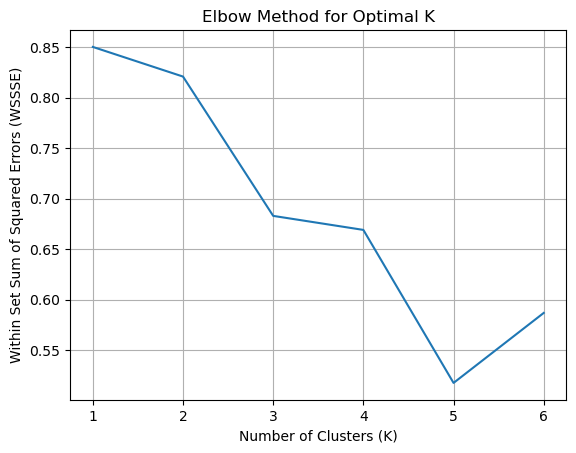

In [ ]:
# Plotting WSSSE values - Elbow method
plt.plot(range(1, 7), wssse_values)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.title('Elbow Method for Optimal K')
plt.grid()
plt.show()

Considering the best k value is 4.

## Clustering on best k value

In [ ]:
kmeans = KMeans(featuresCol="all_features").setK(4)
kmc_results = kmeans.fit(try_airbnb_data).transform(try_airbnb_data)
kmc_results.show(2)

+-------------------+------------------+-------------------+--------------------+-------------+-----+------+-------+-------------+---------------+-------------------+------------+---------+--------+----+-----+----------------+------------+---------------+-----------------+------------+--------------+--------------+---------------+---------------+-------------------+---------------+----------------+--------------------+------------+----------------+-----+----------------------+-----------------------------+------------+--------------------------------+------------+--------------+-------+----------------+--------------+-------+-------------------+------------+-----------------------+------------------------+------------+-----------+----+---+--------------------------+------------------+----+------------------------+-------------------------+----------+---------------------+-----------------+-------+----+-------+-----------+--------------------------+-----------------+-------------------+

## Evaluating the k-means clustering model

In [ ]:
# k-means clustering
output = KMeans_fit.transform(try_airbnb_data)
wssse = evaluator.evaluate(output)
print(f"Within Set Sum of Squared Errors (WSSSE) = {wssse}")

Within Set Sum of Squared Errors (WSSSE) = 0.5870144936576127


## Visualizing cluster

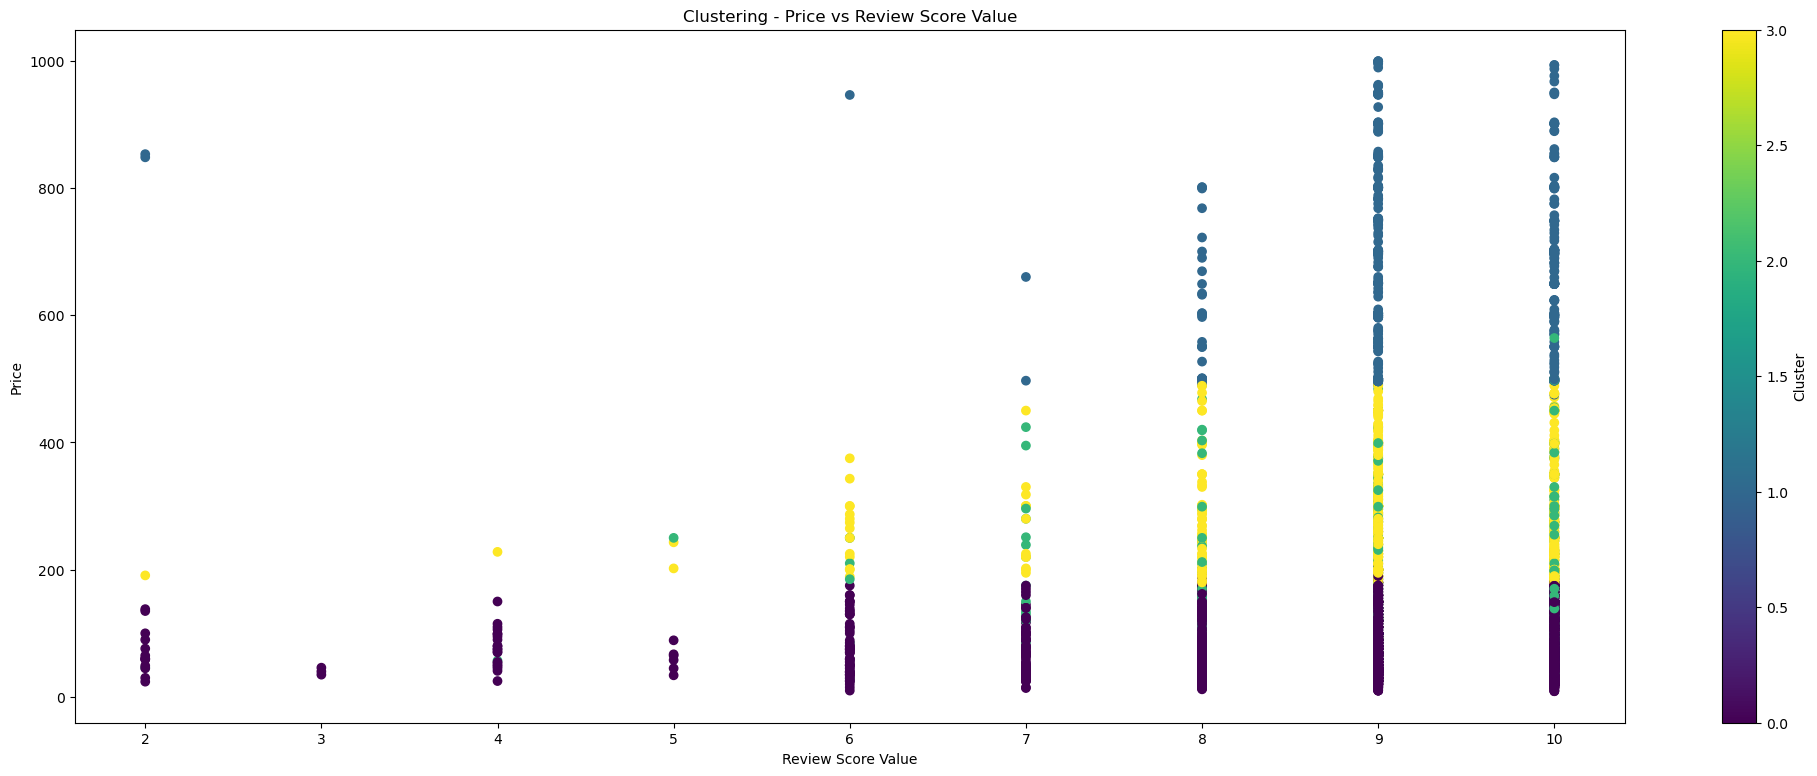

In [ ]:
# Converting to Pandas DataFrame
clustered_data_pd = kmc_results.toPandas()

# Visualizing the results
plt.figure(figsize=(25, 9))
plt.scatter(clustered_data_pd["review_scores_value"], clustered_data_pd["price"], c=clustered_data_pd["prediction"], cmap='viridis')
plt.xlabel("Review Score Value")
plt.ylabel("Price")
plt.title("Clustering - Price vs Review Score Value")
plt.colorbar().set_label("Cluster")
plt.show()

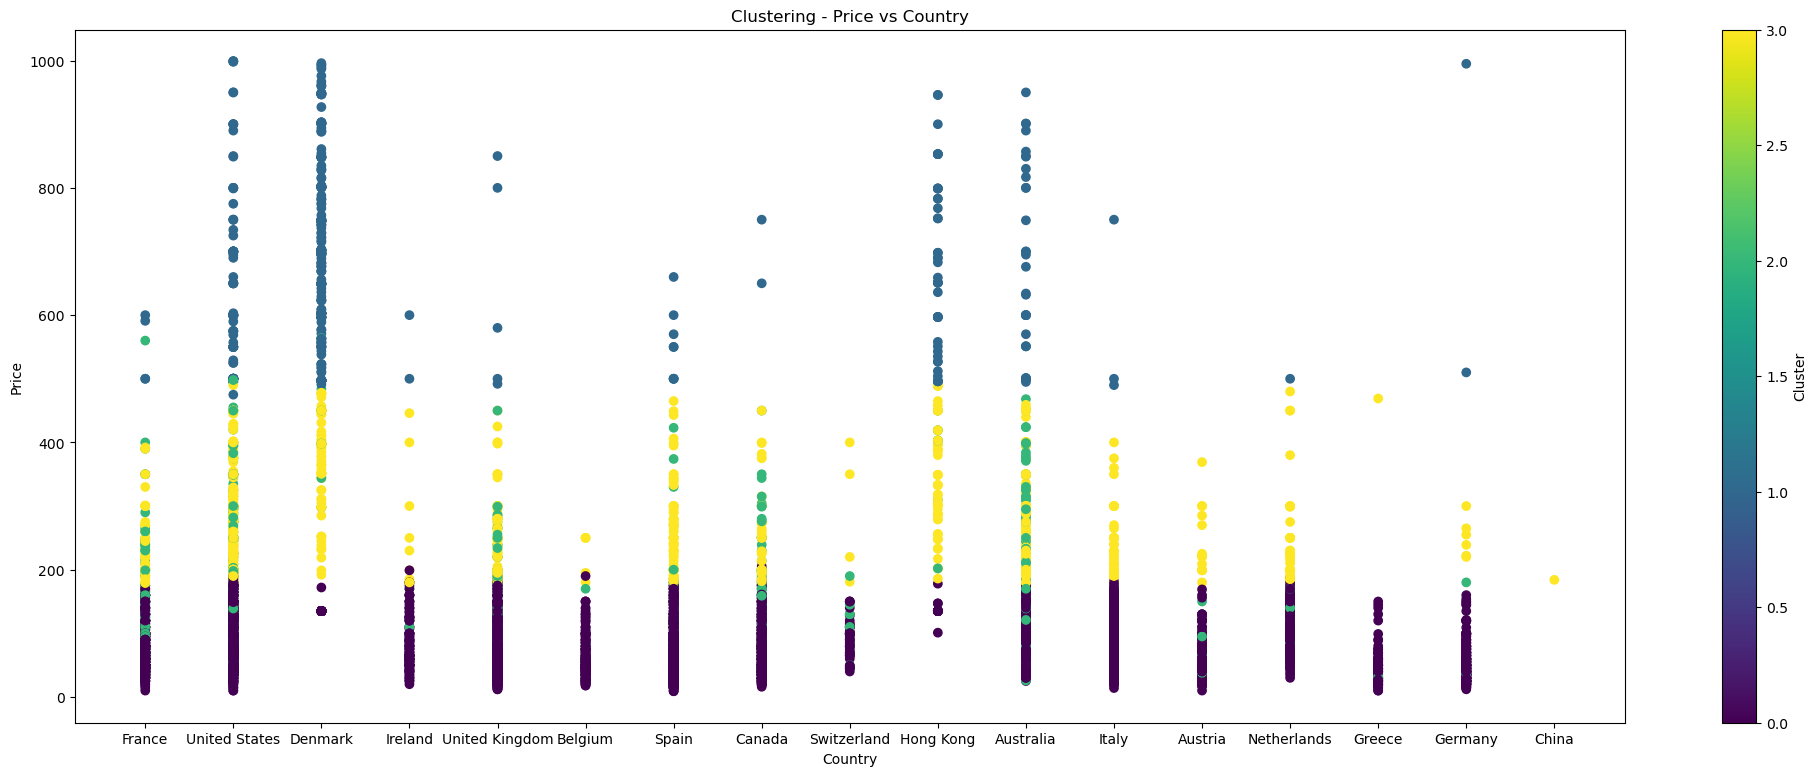

In [ ]:
# Visualizing the results
plt.figure(figsize=(25, 9))
plt.scatter(clustered_data_pd["country"], clustered_data_pd["price"], c=clustered_data_pd["prediction"], cmap='viridis')
plt.xlabel("Country")
plt.ylabel("Price")
plt.title("Clustering - Price vs Country")
plt.colorbar().set_label("Cluster")
plt.show()

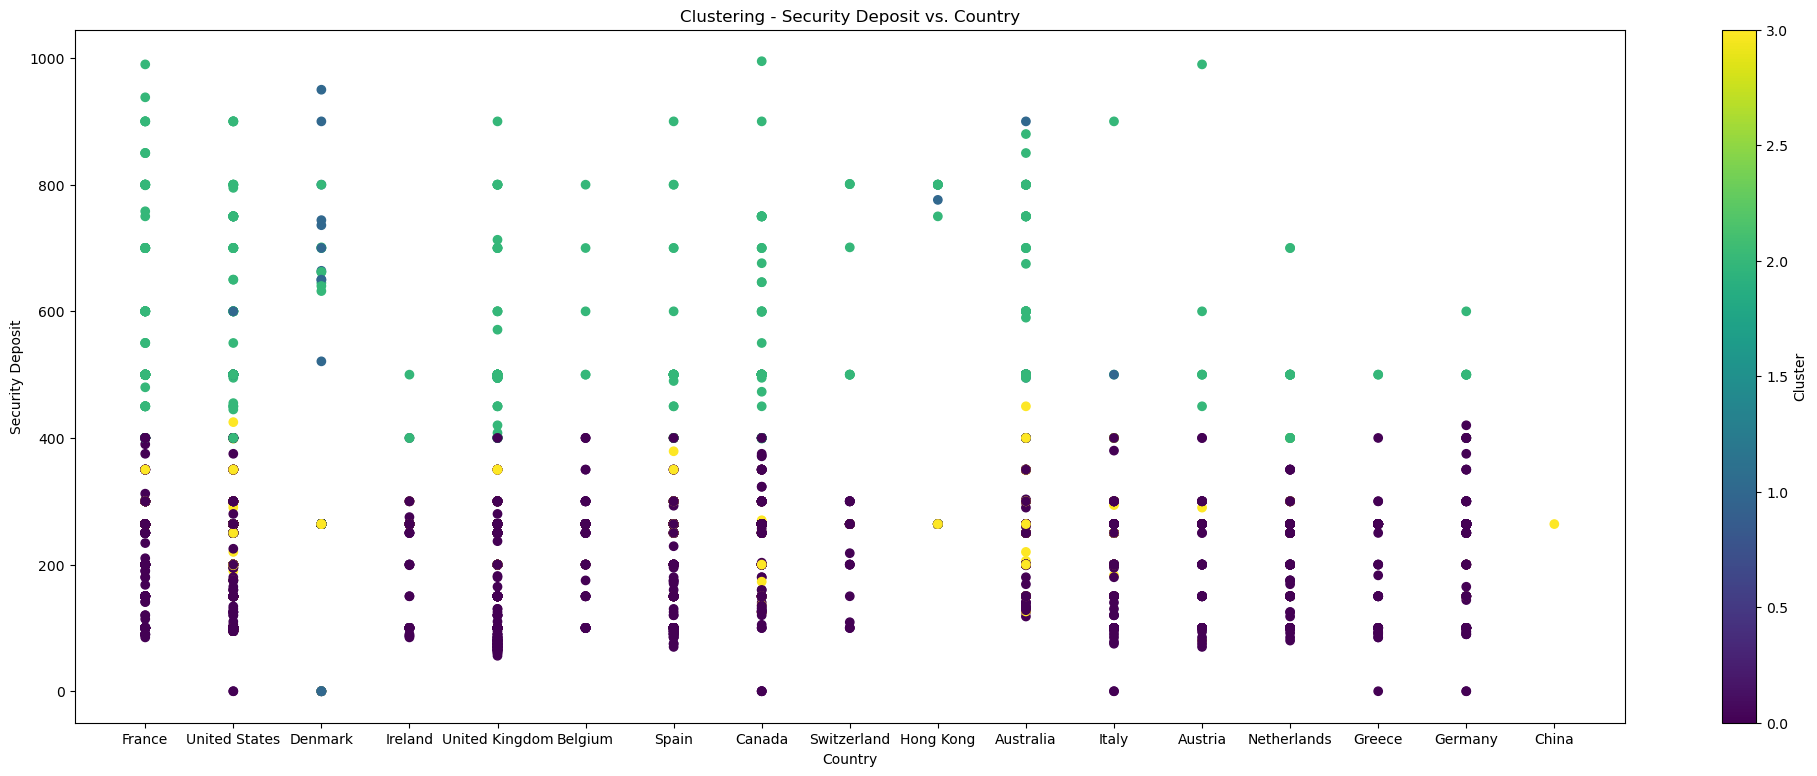

In [ ]:
# Visualizing the results
plt.figure(figsize=(25, 9))
plt.scatter(clustered_data_pd["country"], clustered_data_pd["security_deposit"], c=clustered_data_pd["prediction"], cmap='viridis')
plt.xlabel("Country")
plt.ylabel("Security Deposit")
plt.title("Clustering - Security Deposit vs. Country")
plt.colorbar().set_label("Cluster")
plt.show()

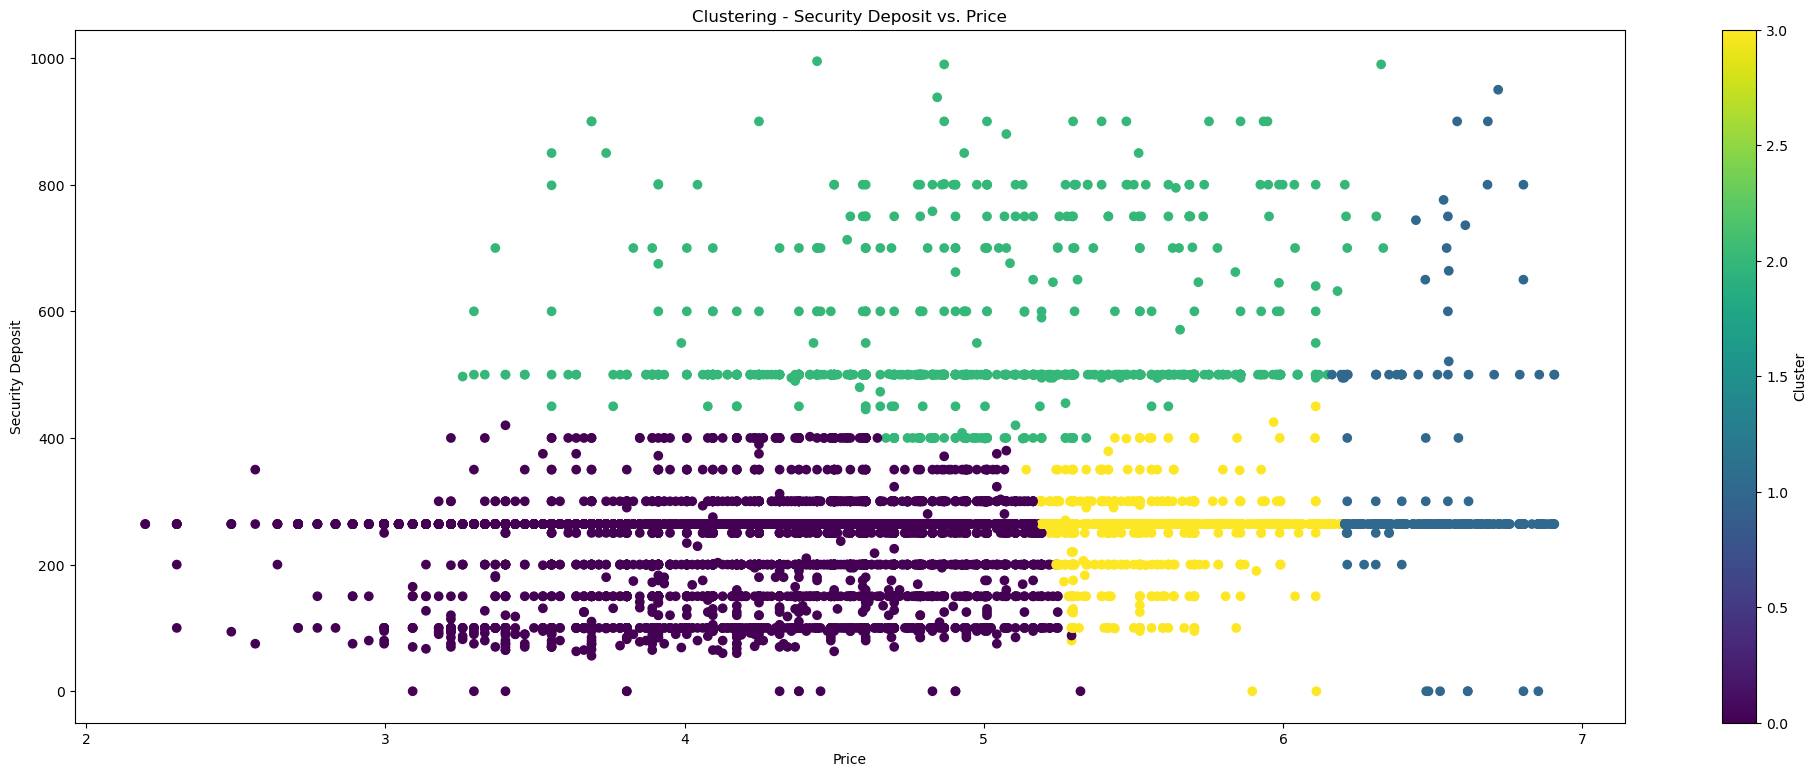

In [ ]:
# Visualizing the results
plt.figure(figsize=(25, 9))
plt.scatter(np.log(clustered_data_pd["price"]), clustered_data_pd["security_deposit"], c=clustered_data_pd["prediction"], cmap='viridis')
plt.xlabel("Price")
plt.ylabel("Security Deposit")
plt.title("Clustering - Security Deposit vs. Price")
plt.colorbar().set_label("Cluster")
plt.show()

In [ ]:
# Assuming your DataFrame is named 'df' and the column containing values 0 to 3 is named 'your_column'
count_per_value = kmc_results.groupBy('prediction').count().orderBy(col("count").desc())

# Show the result
count_per_value.show()


+----------+-----+
|prediction|count|
+----------+-----+
|         0| 7658|
|         3| 1153|
|         2|  736|
|         1|  453|
+----------+-----+



## Classification
How can we predict the pricing category (high or low) of Airbnb listings based on their characteristics?
We'll be using Logistic Regression and see how well we can classify the data based on characteristics such as number of reviews, bedrooms, guests included and others.

In [ ]:
us_records = try_airbnb_data.filter(col("country") == "United States")

# Calculate mean price
mean_price = us_records.agg(mean(col("price")).alias("mean_price")).collect()[0]["mean_price"]

# Create a categorical variable 'price_category' based on comparison with mean price
us_records = us_records.withColumn("price_category", when(col("price") > mean_price, "high").otherwise("low"))

In [ ]:
# Indexing the price_category column
indexer = StringIndexer(inputCol="price_category", outputCol="new_price_category")

# Assemble predictors into a single column
assembler = VectorAssembler(inputCols=["accommodates","bathrooms","bedrooms","beds","security_deposit","cleaning_fee","guests_included","number_of_reviews","Experiences_Offered_str","Neighbourhood_str","State_str","City_str","Cancellation_Policy_str"], outputCol="classification_features")

# Split the data into training and test sets
train_data, test_data = us_records.randomSplit([0.8, 0.2], seed=1000)

In [ ]:
# Define the logistic regression model
lr = LogisticRegression(featuresCol='classification_features', labelCol='new_price_category', maxIter=10)

# Define the pipeline
pipeline = Pipeline(stages=[indexer, assembler, lr])

# Fit the model
model = pipeline.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Show some predictions
predictions.select("price_category", "new_price_category", "probability", "prediction").show()

+--------------+------------------+--------------------+----------+
|price_category|new_price_category|         probability|prediction|
+--------------+------------------+--------------------+----------+
|           low|               0.0|[0.79790155510757...|       0.0|
|           low|               0.0|[0.89545749364250...|       0.0|
|           low|               0.0|[0.74390616580494...|       0.0|
|          high|               1.0|[0.43975829348510...|       1.0|
|           low|               0.0|[0.86768534173745...|       0.0|
|           low|               0.0|[0.51991613095052...|       0.0|
|           low|               0.0|[0.97435000386942...|       0.0|
|          high|               1.0|[0.48894091672532...|       1.0|
|           low|               0.0|[0.81629965258982...|       0.0|
|           low|               0.0|[0.80419242683469...|       0.0|
|          high|               1.0|[0.79041180899350...|       0.0|
|           low|               0.0|[0.6791598284

In [ ]:
predictions=predictions.withColumn("compare",predictions['new_price_category']-predictions['prediction'])
correct=predictions.filter(predictions['compare']==0).count()
incorrect=predictions.filter(predictions['compare']!=0).count()
print(correct/(correct+incorrect))

0.8098859315589354


The logistic regression model used for classification achieved an accuracy of 0.80, indicating that 80% of the time, the model correctly predicts the pricing category of an Airbnb listing as either high or low based on the training data provided. This high level of accuracy suggests that the features selected for the model such as accommodates, bathrooms, bedrooms, beds, security deposit, and others are good predictors of a listing's pricing category.

## Prediction
Review Scores Value is the variable we are trying to predict here based on it's dependance on Property_Type_new, Room_Type_new, Cancellation_Policy_new, host_response_rate, host_listings_count, accommodates, bathrooms, bedrooms, beds and price. We are splitting the dataset to 80% training data and 20% test data. We'll be using Linear Regression Model for this prediction.

In [ ]:
assemblerInputs = ['Property_Type_new', 'Room_Type_new', 'Cancellation_Policy_new', 'host_response_rate', 'host_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price']
vectorAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="linear_features")

lr = LinearRegression(featuresCol='linear_features', labelCol='review_scores_value')

pipeline = Pipeline(stages=[vectorAssembler, lr])

(train_data, test_data) = try_airbnb_data.randomSplit([0.8, 0.2], seed=1000)

model = pipeline.fit(train_data)

predictions = model.transform(test_data)

predictions.select("review_scores_value", "prediction").show()

+-------------------+-----------------+
|review_scores_value|       prediction|
+-------------------+-----------------+
|                  9|9.335614525819116|
|                 10|9.151798919475704|
|                 10|9.199329685632915|
|                  9|9.169727724792669|
|                 10|9.257717997456776|
|                 10|9.251041169148188|
|                  9|8.998045754826718|
|                 10|9.198553697283756|
|                  8| 9.19745469134789|
|                 10| 8.82628510584373|
|                 10|8.805296852635927|
|                  9|8.838131475805652|
|                 10|8.946443789533703|
|                  9|8.805296852635927|
|                  9|8.917055074820398|
|                  9|8.985919655420773|
|                  9|8.812120269235296|
|                  9|8.913563580167438|
|                  9| 8.91705576365108|
|                  8|8.883787948035735|
+-------------------+-----------------+
only showing top 20 rows



We can check how good the regression model is based on metrices like Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="review_scores_value", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data =", rmse)

evaluator = RegressionEvaluator(labelCol="review_scores_value", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)
print("Mean Absolute Error (MAE) on test data =", mae)

Root Mean Squared Error (RMSE) on test data = 0.7595019870834001


Mean Absolute Error (MAE) on test data = 0.5469250376204071


This study's linear regression analysis provides insightful findings on factors influencing Airbnb review scores. The quantified model performance (RMSE and MAE) suggests that the selected predictors effectively capture the variability in review scores.